In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.2 MB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline, AutoTokenizer, AutoModel

In [ ]:
EMBEDDINGS_LABEL = "label_embedding"
THRESHOLD = 0.6
TOP_MATCHES = 5

In [ ]:
model = SentenceTransformer('abd1987/esco-context-skill-extraction')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

In [ ]:
def get_embeddings(x, model, tokenizer=None):
    return model.encode(x, normalize_embeddings=True)

In [ ]:
def get_df(url, name="method_df.npz", df_func=None):
  response = requests.get(url)
  with open(name, "wb") as file:
    file.write(response.content)
  data = np.load(name, allow_pickle=True)
  return pd.DataFrame(df_func(data))

In [ ]:
import ast

esco_df = get_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/abd1987_esco_context_skill_extraction.npz", df_func=lambda x: {
    "label": x["label"],
    "embedding": list(x["embedding"]),
    "label_embedding": list(x["label_embedding"])
})
users_df = pd.read_csv("https://raw.githubusercontent.com/abood1987/recommender/master/data/external_data/user_profiles.csv")
users_df.rename(columns={"user_id": "id"}, inplace=True)
users_df["skills"] = users_df["skills"].apply(ast.literal_eval)
jobs_df = pd.read_csv("https://raw.githubusercontent.com/abood1987/recommender/master/data/external_data/job_profiles.csv")
jobs_df.rename(columns={"job_id": "id"}, inplace=True)
jobs_df["requirements"] = jobs_df["requirements"].apply(ast.literal_eval)
gpt_mapping_df_1 = pd.read_csv("https://raw.githubusercontent.com/abood1987/recommender/master/data/external_data/user_job_matches_1.csv")
gpt_mapping_df_2 = pd.read_csv("https://raw.githubusercontent.com/abood1987/recommender/master/data/external_data/user_job_matches_2.csv")

embeddings_list = np.stack(esco_df[EMBEDDINGS_LABEL].values)

In [ ]:
def find_esco_skill(input_embeddings, esco_embeddings, threshold=0.5, top_n=5):
    sims = cosine_similarity(input_embeddings, esco_embeddings)  # shape: (n_skills, n_esco)

    skill_scores = []
    for row in sims:
        top_indices = row.argsort()[-top_n:][::-1]
        skill_scores.extend([(esco_df.iloc[i]['label'], row[i]) for i in top_indices if row[i] >= threshold])

    # Remove duplicates
    seen = {}
    for skill, score in skill_scores:
        if skill not in seen:
            seen[skill] = score

    top_skills = sorted(seen.items(), key=lambda x: x[1], reverse=True)
    return pd.Series([
        [s for s, _ in top_skills],
        [float(sc) for _, sc in top_skills]
    ])


In [ ]:
users_df[['esco', 'score']] = users_df['skills'].apply(
    lambda x: find_esco_skill(
        get_embeddings(x, model),
        embeddings_list,
        threshold=THRESHOLD,
        top_n=TOP_MATCHES
    )
)
users_df.head(5)

,id,skills,esco,score
0,u1,"[Completed grief counseling workshop, Voluntee...","[show empathy, help clients cope with grief, r...","[0.7965036630630493, 0.7882540225982666, 0.782..."
1,u2,"[Reliable and always on time, Enjoys working w...","[listen actively, meet commitments, communicat...","[0.7173694372177124, 0.6987676620483398, 0.692..."
2,u3,"[Worked in refugee outreach for 6 months, Non-...","[hygiene in a health care setting, keep an ope...","[0.7458361387252808, 0.7263261079788208, 0.724..."
3,u4,"[Organized local cleanup campaigns, Strong sta...","[engage with stakeholders, work within communi...","[0.8151330351829529, 0.8005417585372925, 0.759..."
4,u5,"[Deep love for animals, Volunteered in a shelt...","[animal behaviour, assess animal behaviour, as...","[0.7583835124969482, 0.7498528957366943, 0.686..."


In [ ]:
jobs_df[['esco', 'score']] = jobs_df['requirements'].apply(
    lambda x: find_esco_skill(
        get_embeddings(x, model),
        embeddings_list,
        threshold=THRESHOLD,
        top_n=TOP_MATCHES
    )
)
jobs_df.head(5)

,id,title,requirements,esco,score
0,job1,Hospice Care Assistant,"[Completed qualification course in life, death...","[help clients cope with grief, stages of berea...","[0.8225275278091431, 0.8081057071685791, 0.799..."
1,job2,Social Work Assistant in Residential Community,"[Reliability – adhere to agreements, Empathy f...","[listen actively, keep an open mind, relate em...","[0.7338603734970093, 0.7136117219924927, 0.702..."
2,job3,Software Developer,"[Experience in Python, JavaScript, or Java, Fa...","[Python (computer programming), Agile project ...","[0.8178837299346924, 0.8107383847236633, 0.800..."
3,job4,Graphic Designer,[Proficiency in Adobe Creative Suite (Photosho...,"[Adobe Illustrator, adobe creative suite, Adob...","[0.8934525847434998, 0.8870106339454651, 0.872..."
4,job5,Marketing Assistant,[Knowledge of digital marketing tools and soci...,"[digital marketing techniques, apply social me...","[0.8818119168281555, 0.8799178600311279, 0.876..."


Cosine Similarity (Binary Vector)

In [ ]:
THRESHOLD = 0.5

In [ ]:
all_skills = sorted(set.union(*map(set, users_df['esco'])) | set.union(*map(set, jobs_df['esco'])))
skill_to_idx = {skill: i for i, skill in enumerate(all_skills)}

# Binary vector encoding
def encode_binary(skills):
    vec = np.zeros(len(skill_to_idx))
    for skill in skills:
        if skill in skill_to_idx:
            vec[skill_to_idx[skill]] = 1
    return vec

u_vector = users_df['esco'].apply(encode_binary)
j_vector = jobs_df['esco'].apply(encode_binary)

user_vecs = np.stack(u_vector)
job_vecs = np.stack(j_vector)
sim_matrix_cosine = cosine_similarity(user_vecs, job_vecs)

cosine_df = users_df.copy()
# Match jobs over threshold
cosine_df['matched_jobs'] = [
    list(jobs_df.loc[np.where(row >= THRESHOLD)[0], 'title'])
    for row in sim_matrix_cosine
]
res = cosine_df[cosine_df["matched_jobs"].apply(len) > 0]
print(len(res), res["matched_jobs"].apply(len).sum())
res[["skills", "esco", "matched_jobs"]].head(5)

62 107


,skills,esco,matched_jobs
0,"[Completed grief counseling workshop, Voluntee...","[show empathy, help clients cope with grief, r...","[Hospice Care Assistant, Hospice Care Assistant]"
11,"[Mentored teens at a youth camp, Listens with ...","[deal with aggressive behaviour, assess others...",[Youth Mentoring Program Facilitator]
15,"[Helped people at job fairs with resumes, Can ...","[online job platforms, apply basic programming...",[Job Readiness Workshop Assistant]
25,"[Experience in peer mentoring, Led health educ...","[health education, provide health education, p...","[Health Education Facilitator, Peer Health Edu..."
26,"[Worked with diverse populations, Empathetic l...","[assess others feelings, listen actively, rela...",[Multicultural Outreach Support]


Overlap

In [ ]:
job_titles = jobs_df['title'].tolist()
job_esco_sets = [set(skills) for skills in jobs_df['esco']]

def overlap(u, j):
    return len(u & j) / len(j) if j else 0

def get_matched_jobs(user_skills):
    user_set = set(user_skills)
    return [
        job_titles[i] for i, job_set in enumerate(job_esco_sets)
        if job_set and overlap(user_set, job_set) >= THRESHOLD
    ]

overlap_df = users_df.copy()
overlap_df['matched_jobs'] = overlap_df['esco'].apply(get_matched_jobs)
res = overlap_df[overlap_df["matched_jobs"].apply(len) > 0]
print(len(res), res["matched_jobs"].apply(len).sum())
res[["skills", "esco", "matched_jobs"]].head(5)

60 117


,skills,esco,matched_jobs
0,"[Completed grief counseling workshop, Voluntee...","[show empathy, help clients cope with grief, r...","[Hospice Care Assistant, Hospice Care Assistant]"
11,"[Mentored teens at a youth camp, Listens with ...","[deal with aggressive behaviour, assess others...",[Youth Mentoring Program Facilitator]
15,"[Helped people at job fairs with resumes, Can ...","[online job platforms, apply basic programming...",[Job Readiness Workshop Assistant]
25,"[Experience in peer mentoring, Led health educ...","[health education, provide health education, p...","[Health Education Facilitator, Peer Health Edu..."
26,"[Worked with diverse populations, Empathetic l...","[assess others feelings, listen actively, rela...","[Multicultural Outreach Support, Multilingual ..."


TF-IDF + Cosine

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def list_to_text(lst): return " ".join(lst)
corpus = pd.concat([users_df['esco'], jobs_df['esco']]).apply(list_to_text)
vectorizer = TfidfVectorizer().fit(corpus)
user_tfidf = vectorizer.transform(users_df['esco'].apply(list_to_text))
job_tfidf = vectorizer.transform(jobs_df['esco'].apply(list_to_text))
sim_matrix_tfidf = cosine_similarity(user_tfidf, job_tfidf)

tf_idf_df = users_df.copy()
tf_idf_df['matched_jobs'] = [
    list(jobs_df.loc[np.where(row >= THRESHOLD)[0], 'title'])
    for row in sim_matrix_tfidf
]
res = tf_idf_df[tf_idf_df["matched_jobs"].apply(len) > 0]
print(len(res), res["matched_jobs"].apply(len).sum())
res[["skills", "esco", "matched_jobs"]].head(5)

60 144


,skills,esco,matched_jobs
3,"[Organized local cleanup campaigns, Strong sta...","[engage with stakeholders, work within communi...",[Community Development Coordinator]
4,"[Deep love for animals, Volunteered in a shelt...","[animal behaviour, assess animal behaviour, as...",[Animal Shelter Assistant]
5,"[Proficient in Microsoft Word and Excel, Handl...","[perform multiple tasks at the same time, use ...","[Administrative Assistant, Administrative Assi..."
11,"[Mentored teens at a youth camp, Listens with ...","[deal with aggressive behaviour, assess others...",[Youth Mentoring Program Facilitator]
15,"[Helped people at job fairs with resumes, Can ...","[online job platforms, apply basic programming...",[Job Readiness Workshop Assistant]


Fuzzy matching

In [ ]:
from rapidfuzz import process, fuzz, utils
import numpy as np
FUZZY_THRESHOLD = 60  # rapidfuzz scores go from 0–100

# Pre-extract job data once (avoids iloc slowdown)
job_titles = jobs_df['title'].tolist()
job_requirements = jobs_df['esco'].tolist()

def fuzzy_match_user_to_job(user_skills, job_skills):
    if not user_skills or not job_skills:
        return 0.0

    # Compute fuzzy similarity matrix
    sim_matrix = process.cdist(
        user_skills,
        job_skills,
        scorer=fuzz.token_sort_ratio,
        score_cutoff=FUZZY_THRESHOLD,
        dtype=np.uint8,
        processor=utils.default_process
    )

    matched_mask = np.any(sim_matrix, axis=1)
    return matched_mask.sum() / len(user_skills)

# Faster loop using apply
def get_fuzzy_matches(user_skills):
    return [
        job_titles[i]
        for i, job_sk in enumerate(job_requirements)
        if fuzzy_match_user_to_job(user_skills, job_sk) >= THRESHOLD
    ]

fuzzy_df = users_df.copy()
fuzzy_df["matched_jobs"] = users_df["esco"].apply(get_fuzzy_matches)

# Filter for users with at least 1 match
res = fuzzy_df[fuzzy_df["matched_jobs"].apply(len) > 0]
print(len(res), res["matched_jobs"].apply(len).sum())
res[["skills", "esco", "matched_jobs"]].head(5)


90 225


,skills,esco,matched_jobs
0,"[Completed grief counseling workshop, Voluntee...","[show empathy, help clients cope with grief, r...","[Hospice Care Assistant, Hospice Care Assistant]"
3,"[Organized local cleanup campaigns, Strong sta...","[engage with stakeholders, work within communi...",[Community Development Coordinator]
4,"[Deep love for animals, Volunteered in a shelt...","[animal behaviour, assess animal behaviour, as...","[Animal Shelter Assistant, Pet Shelter Support..."
5,"[Proficient in Microsoft Word and Excel, Handl...","[perform multiple tasks at the same time, use ...",[Administrative Assistant]
10,"[Used InfusionSoft in previous internship, Com...","[meet deadlines, organise information, objects...","[Graphic Designer, Administrative Assistant, A..."


Embedding Cosine

In [ ]:
u_esco_emb = users_df['esco'].apply(lambda x: get_embeddings(', '.join(x), model))
j_esco_emb = jobs_df['esco'].apply(lambda x: get_embeddings(', '.join(x), model))

user_emb_matrix = np.stack(u_esco_emb)
job_emb_matrix = np.stack(j_esco_emb)

sim_matrix_emb = cosine_similarity(user_emb_matrix, job_emb_matrix)

# Match jobs above threshold
embedding_df = users_df.copy()
embedding_df['matched_jobs'] = [
    list(jobs_df.loc[np.where(row >= THRESHOLD)[0], 'title'])
    for row in sim_matrix_emb
]
res = embedding_df[embedding_df["matched_jobs"].apply(len) > 0]
print(len(res), res["matched_jobs"].apply(len).sum())
res[["skills", "esco", "matched_jobs"]].head(5)

195 1171


,skills,esco,matched_jobs
0,"[Completed grief counseling workshop, Voluntee...","[show empathy, help clients cope with grief, r...","[Hospice Care Assistant, Social Work Assistant..."
1,"[Reliable and always on time, Enjoys working w...","[listen actively, meet commitments, communicat...",[Social Work Assistant in Residential Communit...
2,"[Worked in refugee outreach for 6 months, Non-...","[hygiene in a health care setting, keep an ope...",[Social Work Assistant in Residential Communit...
3,"[Organized local cleanup campaigns, Strong sta...","[engage with stakeholders, work within communi...","[Fundraising and Grant Support Officer, Volunt..."
4,"[Deep love for animals, Volunteered in a shelt...","[animal behaviour, assess animal behaviour, as...","[Animal Shelter Assistant, Animal Behavior Obs..."


Skill Hierarchy Match

In [ ]:
broader_df = get_df("https://raw.githubusercontent.com/abood1987/recommender/master/data/methods_results/broader_list.npz", df_func=lambda x: {
    "label": x["label"],
    "uri": x["uri"],
    "broader": x["broader"],
    "broader_label": x["broader_label"]
})
broader_map = broader_df.set_index("label")[["uri", "broader", "broader_label"]].apply(tuple, axis=1).to_dict()
broader_set = set(broader_df["broader"].to_list())


# Build user and job skill sets expanded by broader

u_df = users_df.copy()
j_df = jobs_df.copy()

def expand_with_broader(skills):
    expanded = set(skills)
    for skill in skills:
        uri, broader, broader_label = broader_map.get(skill, (None, None, None))
        if broader_label:
            expanded.add(broader_label)
    return list(expanded)

u_df['expanded'] = u_df['esco'].apply(expand_with_broader)
j_df['expanded'] = j_df['esco'].apply(expand_with_broader)

def overlap(u, j):
    return len(set(u) & set(j)) / len(set(j)) if j else 0

hierarchy_df = u_df.copy()
hierarchy_df['matched_jobs'] = [
    [j_df.iloc[i]['title'] for i in range(len(j_df))
     if overlap(u, j_df.iloc[i]['expanded']) >= THRESHOLD]
    for u in u_df['expanded']
]
res = hierarchy_df[hierarchy_df["matched_jobs"].apply(len) > 0]
print(len(res), res["matched_jobs"].apply(len).sum())
res[["skills", "esco", "matched_jobs"]].head(5)

79 150


,skills,esco,matched_jobs
11,"[Mentored teens at a youth camp, Listens with ...","[deal with aggressive behaviour, assess others...",[Youth Mentoring Program Facilitator]
15,"[Helped people at job fairs with resumes, Can ...","[online job platforms, apply basic programming...",[Job Readiness Workshop Assistant]
25,"[Experience in peer mentoring, Led health educ...","[health education, provide health education, p...","[Health Education Facilitator, Peer Health Edu..."
26,"[Worked with diverse populations, Empathetic l...","[assess others feelings, listen actively, rela...","[Multicultural Outreach Support, Multilingual ..."
27,"[Animal lover with experience caring for pets,...","[exercise patience, react calmly in stressful ...","[Animal Welfare Program Assistant, Animal Care..."


Embedding Hierarchy Cosine

In [ ]:
u_df = users_df.copy()
j_df = jobs_df.copy()

u_df['esco_emb'] = u_df['esco'].apply(expand_with_broader).apply(lambda x: get_embeddings(', '.join(x), model))
j_df['esco_emb'] = j_df['esco'].apply(expand_with_broader).apply(lambda x: get_embeddings(', '.join(x), model))

user_emb_matrix = np.stack(u_df['esco_emb'])
job_emb_matrix = np.stack(j_df['esco_emb'])

sim_matrix_emb = cosine_similarity(user_emb_matrix, job_emb_matrix)

# Match jobs above threshold
embedding_hir_df = u_df.copy()
embedding_hir_df['matched_jobs'] = [
    list(j_df.loc[np.where(row >= THRESHOLD)[0], 'title'])
    for row in sim_matrix_emb
]
res = embedding_hir_df[embedding_hir_df["matched_jobs"].apply(len) > 0]
print(len(res), res["matched_jobs"].apply(len).sum())
res[["skills", "esco", "matched_jobs"]]

202 1877


,skills,esco,matched_jobs
0,"[Completed grief counseling workshop, Voluntee...","[show empathy, help clients cope with grief, r...","[Hospice Care Assistant, Social Work Assistant..."
1,"[Reliable and always on time, Enjoys working w...","[listen actively, meet commitments, communicat...","[Hospice Care Assistant, Social Work Assistant..."
2,"[Worked in refugee outreach for 6 months, Non-...","[hygiene in a health care setting, keep an ope...",[Social Work Assistant in Residential Communit...
3,"[Organized local cleanup campaigns, Strong sta...","[engage with stakeholders, work within communi...","[Community Development Coordinator, Community ..."
4,"[Deep love for animals, Volunteered in a shelt...","[animal behaviour, assess animal behaviour, as...","[Animal Shelter Assistant, Animal Behavior Obs..."
...,...,...,...
204,"[PHP and Laravel developer, Experience with Bl...","[ASP.NET, service-oriented modelling, Joomla, ...","[Software Developer, Data Analyst, UX/UI Desig..."
205,"[Android development using Kotlin, Used Fireba...","[LDAP, Android (mobile operating systems), obj...",[Mobile App Developer]
206,[Built SQL-heavy reporting tools with Python +...,"[PostgreSQL, XQuery, Oracle Relational Databas...",[Data Analyst]
207,"[Frontend-focused: HTML5, CSS3, JavaScript, Ba...","[use markup languages, JavaScript Framework, m...",[UX/UI Designer]


In [ ]:
dfs_dict = {
    "cosine": cosine_df,
    "overlap": overlap_df,
    "tfidf": tf_idf_df,
    "fuzzy": fuzzy_df,
    "embedding": embedding_df,
    "hierarchy + overlap": hierarchy_df,
}

summary = pd.DataFrame({
    "method": dfs_dict.keys(),
    "matched users": [df['matched_jobs'].apply(len).gt(0).sum() for df in dfs_dict.values()],
    "matched jobs": [df["matched_jobs"].apply(len).sum() for df in dfs_dict.values()]
})
summary

,method,matched users,matched jobs
0,cosine,62,107
1,overlap,60,117
2,tfidf,60,144
3,fuzzy,90,225
4,embedding,195,1171
5,hierarchy + overlap,79,150


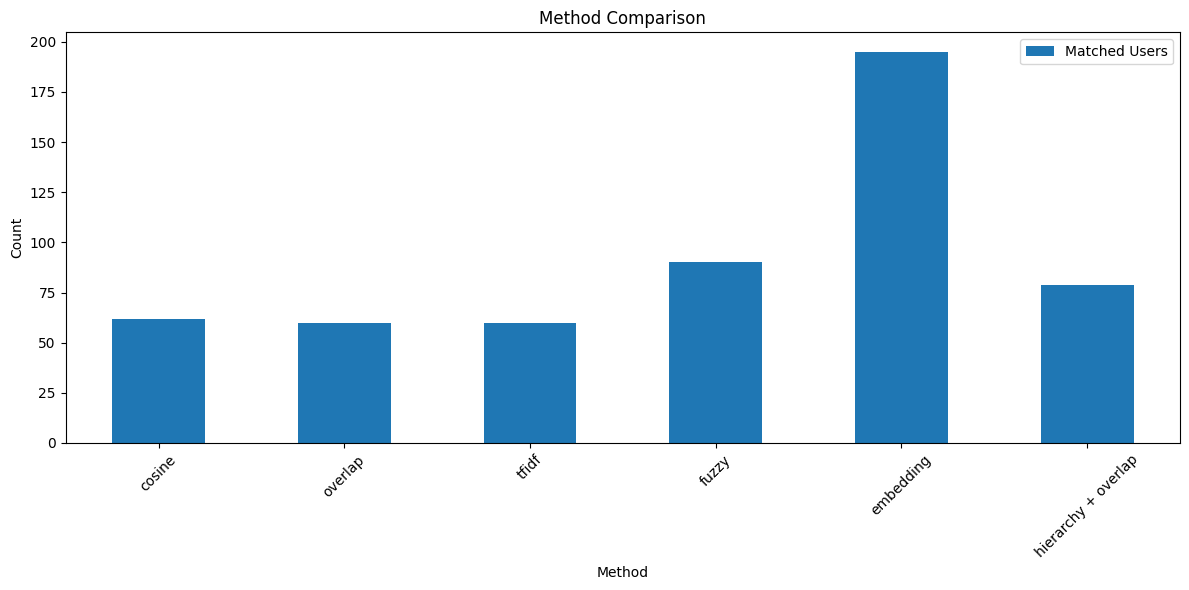

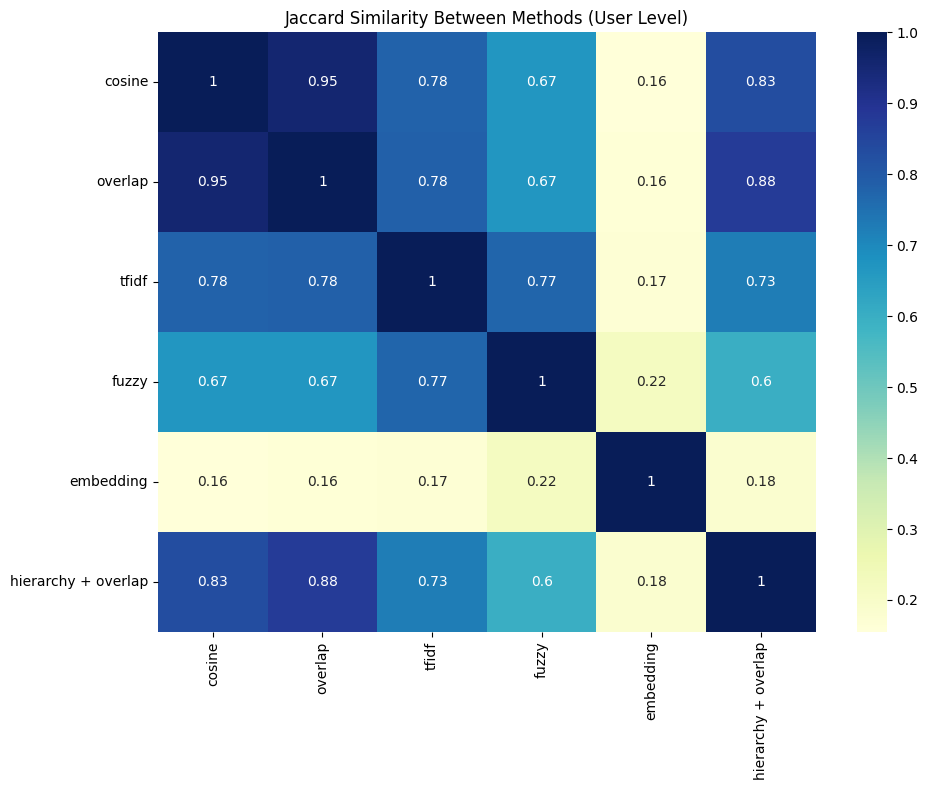

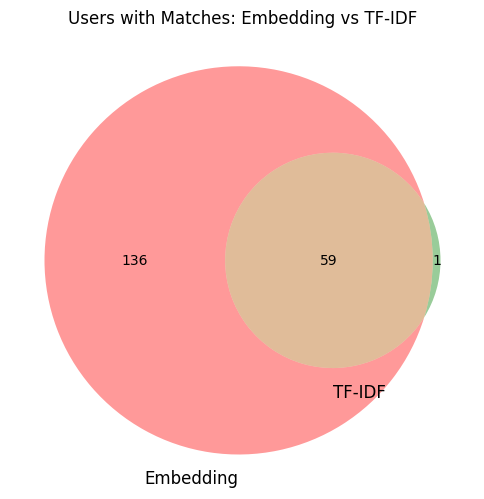

📋 Method Comparison Summary:
             Method  Matched Users  Matched Jobs  Avg Jobs/User  Unique Jobs  Unique Jobs (Excl. Common)
             cosine             62           107       0.509524           12                           2
            overlap             60           117       0.557143           12                           2
              tfidf             60           144       0.685714           21                          11
              fuzzy             90           225       1.071429           41                          31
          embedding            195          1171       5.576190           55                          45
hierarchy + overlap             79           150       0.714286           13                           3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
import warnings
warnings.filterwarnings("ignore")

# Use your provided dictionary
methods = dfs_dict

# 1. Basic stats
stats = []

for name, df in methods.items():
    match_counts = df["matched_jobs"].apply(len)
    matched_users = match_counts.gt(0).sum()
    avg_jobs = match_counts.mean()
    unique_jobs = len(set(job for jobs in df["matched_jobs"] for job in jobs))
    total_matched = match_counts.sum()
    stats.append((name, matched_users, total_matched, avg_jobs, unique_jobs))

stats_df = pd.DataFrame(stats, columns=["Method", "Matched Users", "Matched Jobs", "Avg Jobs/User", "Unique Jobs"])

# 2. Jaccard Similarity Between Methods (User-Level)
def jaccard_for_users(df1, df2):
    jaccards = []
    for a, b in zip(df1["matched_jobs"], df2["matched_jobs"]):
        set_a, set_b = set(a), set(b)
        if set_a or set_b:
            jaccards.append(len(set_a & set_b) / len(set_a | set_b))
        else:
            jaccards.append(1.0)
    return np.mean(jaccards)

method_names = list(methods.keys())
jaccard_matrix = np.zeros((len(method_names), len(method_names)))

for i in range(len(method_names)):
    for j in range(len(method_names)):
        jaccard_matrix[i, j] = jaccard_for_users(methods[method_names[i]], methods[method_names[j]])

# 3. Common and Unique Job Counts
job_sets = {
    name: set(job for jobs in df["matched_jobs"] for job in jobs)
    for name, df in methods.items()
}
common_jobs = set.intersection(*job_sets.values())

unique_jobs = {
    name: len(job_set - common_jobs)
    for name, job_set in job_sets.items()
}
stats_df["Unique Jobs (Excl. Common)"] = stats_df["Method"].map(unique_jobs)

# 4. Bar Plot - Stats
stats_df[["Method", "Matched Users"]].plot(x="Method", kind="bar", figsize=(12, 6), title="Method Comparison")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.tight_layout()
plt.show()
print("")

# 5. Heatmap - Jaccard Similarity
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_matrix, xticklabels=method_names, yticklabels=method_names, annot=True, cmap="YlGnBu")
plt.title("Jaccard Similarity Between Methods (User Level)")
plt.tight_layout()
plt.show()
print("")

# 6. Venn Diagram: Embedding vs TF-IDF (just an example)
embedding_users = set(methods["embedding"][methods["embedding"]["matched_jobs"].apply(len) > 0].index)
tfidf_users = set(methods["tfidf"][methods["tfidf"]["matched_jobs"].apply(len) > 0].index)

plt.figure(figsize=(6, 6))
venn2([embedding_users, tfidf_users], set_labels=("Embedding", "TF-IDF"))
plt.title("Users with Matches: Embedding vs TF-IDF")
plt.show()
print("")

# 7. Show Summary Table
print("Method Comparison Summary:")
print(stats_df.to_string(index=False))


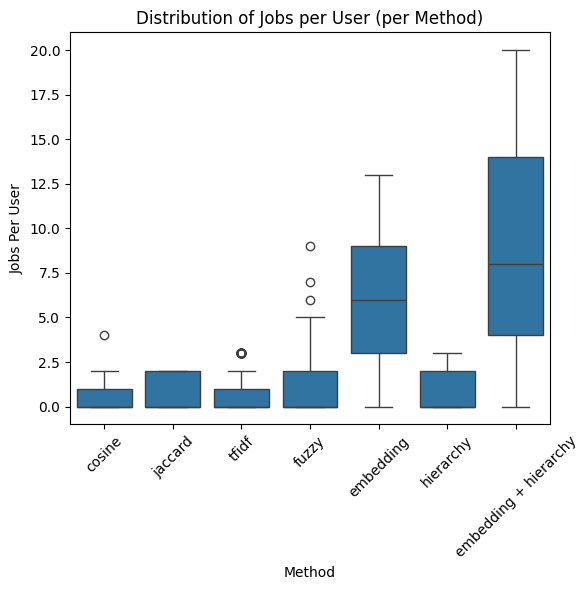

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to long-format DataFrame
long_df = []

for method_name, df in dfs_dict.items():
    for job_list in df["matched_jobs"]:
        long_df.append({
            "Method": method_name,
            "Jobs Per User": len(job_list)
        })

plot_df = pd.DataFrame(long_df)

# Draw boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(data=plot_df, x="Method", y="Jobs Per User")
plt.title("Distribution of Jobs per User (per Method)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()